<a href="https://colab.research.google.com/github/adamgrzanek/CV_damaged_car_detection/blob/main/CV_damaged_car_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
import plotly.offline as po
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import cv2
import imutils
from google.colab.patches import cv2_imshow

# do zapisania jako znacznik daty i czasu
from datetime import datetime
import pytz # do stref czasowych

# # do zachowania pewnych objektów, które stworzymy po drodze (słownik z mapowaniem etykiet)
import pickle
from imutils import paths # do wylistownia wszystkich obrazów w danym katalogu ****
import shutil # do przenoszenia plików itp.

# suppress logs
# do ograniczenia printowania logów (dzienników)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # do augumentacji danych
from tensorflow.keras.callbacks import ModelCheckpoint  # do zapisania najlepszego modelu podczas treniwania
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam  # optymalizator

from keras import regularizers

from keras.models import Sequential  # do prostych modeli (warstwa po warstwie, szkielet)
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import load_model

In [ ]:
print(f'Tensorflow version: {tf.__version__}') # 2.9.1
# 26.12.2023 -> 2.15.0

Tensorflow version: 2.15.0


### Prevent Google Colab from disconnecting

In [ ]:
# zmienić ustawienia zasilania i wygaszacz!!!!

# https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#8c1e
# https://www.youtube.com/watch?v=RpQaAbMmqkA

# inspect / console

# allow pasting
# paste:

# function KeepClicking(){
# console.log("Clicking");
# document.querySelector("colab-connect-button").click()
# }

# setInterval(KeepClicking,60000)

## Wczytanie danych

In [ ]:
# I:\PycharmProjects\computer-vision-course\06_6_cars_classification_ag    ->    'cars_image.zip'

In [ ]:
!pwd

/content


In [ ]:
!ls

cars_image_2.zip  sample_data


In [ ]:
! unzip cars_image_2.zip

In [ ]:
base_path = 'cars_image_2'

cars_dir = os.listdir(base_path)
print(cars_dir)

['ok_cars', 'damaged_cars']


In [ ]:
# rename

for dir in cars_dir:
    print(dir)
    path = os.path.join(base_path, dir)
    images = paths.list_images(path)
    print(path)
    for n, img in enumerate(sorted(images), start=1):
        #print(n, image)
        if img.split('.')[-1] in ['jpeg', 'jpg', 'png']:
            new_file_name = os.path.join(path, f'{n:04}.jpg')
            os.rename(img, new_file_name)

ok_cars
cars_image_2/ok_cars
damaged_cars
cars_image_2/damaged_cars


In [ ]:
ok_cars_path = base_path + '/' + 'ok_cars'
damaged_cars_path = base_path + '/' + 'damaged_cars'


print(f'Ilość zdjęć w katalogu {ok_cars_path}: {len(os.listdir(ok_cars_path))}')
print(f'Ilość zdjęć w katalogu {damaged_cars_path}: {len(os.listdir(damaged_cars_path))}')

Ilość zdjęć w katalogu cars_image_2/ok_cars: 1460
Ilość zdjęć w katalogu cars_image_2/damaged_cars: 547


### usunięcie zbędnych plików

In [ ]:
files = !ls *.jpg -l

In [ ]:
files = [f.split()[-1] for f in files]

In [ ]:
files

['0603.jpg',
 '0605.jpg',
 '0609.jpg',
 '1449.jpg',
 '1453.jpg',
 '1455.jpg',
 '1458.jpg',
 'damaged_car_005.jpg',
 'damaged_car_017.jpg',
 'damaged_car_034.jpg',
 'damaged_car_050.jpg',
 'damaged_car_053.jpg',
 'damaged_car_054.jpg',
 'damaged_car_055.jpg',
 'damaged_car_067.jpg',
 'damaged_car_068.jpg',
 'damaged_car_069.jpg',
 'damaged_car_073.jpg',
 'Image_15.jpg',
 'Image_18.jpg',
 'Image_33.jpg',
 'Image_34.jpg',
 'Image_37.jpg',
 'Image_39.jpg',
 'Image_4.jpg',
 'Image_9.jpg']

In [ ]:
len(files)

26

In [ ]:
for f in files:
    #print(f)
    os.remove('./' + f)

In [ ]:
#os.remove('./cars_image')
rm -rf splitted_images  # usunięcie katalogu

SyntaxError: ignored

In [ ]:
rm -rf cars_image  # usunięcie katalogu

## Eksploracja wczytanych zdjęć

cars_image_2/ok_cars/0481.jpg


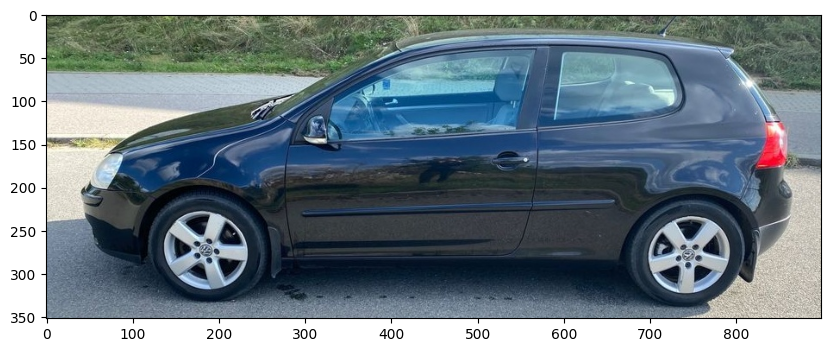

In [ ]:
# https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=eFN7-fUKs-Bu
#from tensorflow.keras.preprocessing import image
#@title Wybierz indeks przykładowego zdjęcia auta bez uszkodzeń:

index = 481 #@param {type:'slider', min:1, max:1460}
img_path = ok_cars_path + f'/{index:04}.jpg'

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
print(img_path)

cars_image_2/damaged_cars/0169.jpg


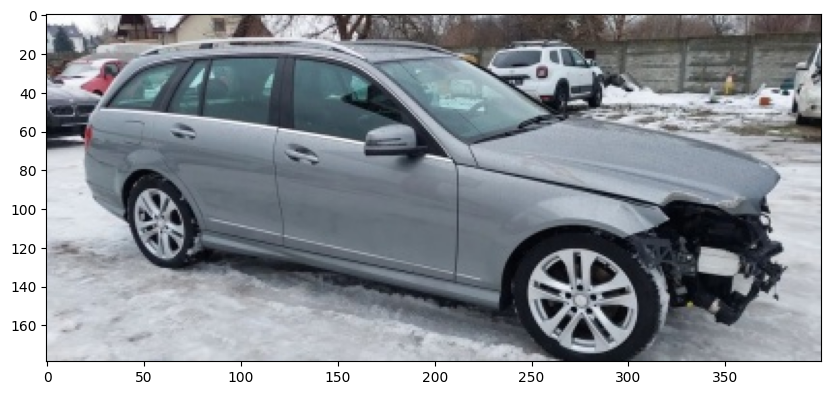

In [ ]:
# https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=eFN7-fUKs-Bu

#@title Wybierz indeks przykładowego zdjęcia uszkodzonego auta:

index = 169 #@param {type:'slider', min:1, max:547}
img_path = damaged_cars_path + f'/{index:04}.jpg'

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
print(img_path)

In [ ]:
# pomocnicze

import ipywidgets as widgets
#slider = widgets.IntSlider(value=1, max=len(train_dict))
slider = widgets.IntSlider(
    value=666,
    min=0,
    max=1000,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
display(slider)


# The current value of the slider
slider.value

IntSlider(value=666, description='Test:', max=1000)

666

## Podział danych (Tworzenie 3 katalogów i kopiowanie plików)

In [ ]:
cars_dir

['ok_cars', 'damaged_cars']

In [ ]:
# rm -rf splitted_images  # usunięcie katalogu

In [ ]:
CLS_1 = cars_dir[0] # 'ok_cars'
CLS_2 = cars_dir[1] # 'damaged_cars'
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
DATA_DIR = r'./splitted_images'

raw_no_of_files = {}
classes = [CLS_1, CLS_2]

number_of_samples = [(dir, len(os.listdir(os.path.join(base_path, dir)))) for dir in classes]
print(number_of_samples)  # [('damaged_cars', 444), ('ok_cars', 1461)]


if not os.path.exists(DATA_DIR): os.mkdir(DATA_DIR)

# Katalogi do zbiorów: train, valid, test
train_dir = os.path.join(DATA_DIR, 'train')
valid_dir = os.path.join(DATA_DIR, 'valid')
test_dir = os.path.join(DATA_DIR, 'test')

train_cls_1_dir = os.path.join(train_dir, CLS_1)
valid_cls_1_dir = os.path.join(valid_dir, CLS_1)
test_cls_1_dir = os.path.join(test_dir, CLS_1)

train_cls_2_dir = os.path.join(train_dir, CLS_2)
valid_cls_2_dir = os.path.join(valid_dir, CLS_2)
test_cls_2_dir = os.path.join(test_dir, CLS_2)

for dir in (train_dir, valid_dir, test_dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

for dir in (train_cls_1_dir, valid_cls_1_dir, test_cls_1_dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

for dir in (train_cls_2_dir, valid_cls_2_dir, test_cls_2_dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

print('\n', '-' * 40)
print('[INFO] Wczytanie nazw plików...')
cls_1_names = os.listdir(os.path.join(base_path, CLS_1))
cls_2_names = os.listdir(os.path.join(base_path, CLS_2))

print('[INFO] Walidacja poprawności nazw...')
cls_1_names = [fname for fname in cls_1_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
cls_2_names = [fname for fname in cls_2_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

# Przetasowanie nazw plików
np.random.shuffle(cls_1_names)
np.random.shuffle(cls_2_names)

print('\n', '-' * 40)
print(f'[INFO] Liczba obrazów w zbiorze {CLS_1}: {len(cls_1_names)}')
print(f'[INFO] Liczba obrazów w zbiorze {CLS_2}: {len(cls_2_names)}')

train_idx_cls_1 = int(TRAIN_RATIO * len(cls_1_names))
valid_idx_cls_1 = train_idx_cls_1 + int(VALID_RATIO * len(cls_1_names))

train_idx_cls_2 = int(TRAIN_RATIO * len(cls_2_names))
valid_idx_cls_2 = train_idx_cls_2 + int(VALID_RATIO * len(cls_2_names))

print('\n', '-' * 40)
print('[INFO] Kopiowanie plików do katalogów docelowych...')
for i, fname in enumerate(cls_1_names):
    if i <= train_idx_cls_1:
        src = os.path.join(base_path, CLS_1, fname)
        dst = os.path.join(train_cls_1_dir, fname)
        shutil.copyfile(src, dst)
    if train_idx_cls_1 < i <= valid_idx_cls_1:
        src = os.path.join(base_path, CLS_1, fname)
        dst = os.path.join(valid_cls_1_dir, fname)
        shutil.copyfile(src, dst)
    if valid_idx_cls_1 < i <= len(cls_1_names):
        src = os.path.join(base_path, CLS_1, fname)
        dst = os.path.join(test_cls_1_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(cls_2_names):
    if i <= train_idx_cls_2:
        src = os.path.join(base_path, CLS_2, fname)
        dst = os.path.join(train_cls_2_dir, fname)
        shutil.copyfile(src, dst)
    if train_idx_cls_2 < i <= valid_idx_cls_2:
        src = os.path.join(base_path, CLS_2, fname)
        dst = os.path.join(valid_cls_2_dir, fname)
        shutil.copyfile(src, dst)
    if valid_idx_cls_2 < i <= len(cls_2_names):
        src = os.path.join(base_path, CLS_2, fname)
        dst = os.path.join(test_cls_2_dir, fname)
        shutil.copyfile(src, dst)

print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze treningowym: {len(os.listdir(train_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze validacyjnym: {len(os.listdir(valid_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze testowym: {len(os.listdir(test_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze treningowym: {len(os.listdir(train_cls_2_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze validacyjnym: {len(os.listdir(valid_cls_2_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze testowym: {len(os.listdir(test_cls_2_dir))}')

[('ok_cars', 1460), ('damaged_cars', 547)]

 ----------------------------------------
[INFO] Wczytanie nazw plików...
[INFO] Walidacja poprawności nazw...

 ----------------------------------------
[INFO] Liczba obrazów w zbiorze ok_cars: 1460
[INFO] Liczba obrazów w zbiorze damaged_cars: 547

 ----------------------------------------
[INFO] Kopiowanie plików do katalogów docelowych...
[INFO] Liczba obrazów klasy ok_cars w zbiorze treningowym: 1022
[INFO] Liczba obrazów klasy ok_cars w zbiorze validacyjnym: 292
[INFO] Liczba obrazów klasy ok_cars w zbiorze testowym: 146
[INFO] Liczba obrazów klasy damaged_cars w zbiorze treningowym: 383
[INFO] Liczba obrazów klasy damaged_cars w zbiorze validacyjnym: 109
[INFO] Liczba obrazów klasy damaged_cars w zbiorze testowym: 55


## Stałe

In [ ]:
LEARNING_RATE = 0.001

EPOCHS = 50
BATCH_SIZE = 32

#INPUT_SHAPE = (150, 150, 3)
#INPUT_SHAPE = (150, 150, 1)
#INPUT_SHAPE = (180, 180, 3)
INPUT_SHAPE = (224, 224, 3)

TRAIN_DIR = 'splitted_images/train'
VALID_DIR = 'splitted_images/valid'
TEST_DIR = 'splitted_images/test'

In [ ]:
if not os.path.exists('output'):
    os.mkdir('output')

## Funkcje

In [ ]:
# wykres historii uczenia
def plot_hist(history, filename, show_plot=False):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = make_subplots(rows=2, cols=1, subplot_titles=('Accuracy', 'Loss'))

    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='train_accuracy',
                             mode='markers+lines', marker_color='#f29407'), row=1, col=1)
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='valid_accuracy',
                             mode='markers+lines', marker_color='#0771f2'), row=1, col=1)
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='train_loss',
                             mode='markers+lines', marker_color='#f29407'), row=2, col=1)
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='valid_loss',
                             mode='markers+lines', marker_color='#0771f2'), row=2, col=1)

    fig.update_xaxes(title_text='Liczba epok', row=1, col=1)
    fig.update_xaxes(title_text='Liczba epok', row=2, col=1)
    fig.update_yaxes(title_text='Accuracy', row=1, col=1)
    fig.update_yaxes(title_text='Loss', row=2, col=1)
    fig.update_layout(width=1400, height=1000, title=f"Metrics: {MODEL_NAME}")

    po.plot(fig, filename=filename, auto_open=False)

    if show_plot:
        #return po.plot(fig)
        fig.show()


In [ ]:
def display_augmented_images(directory, index):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    #fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    fnames = sorted([os.path.join(directory, fname) for fname in os.listdir(directory)])
    img_path = fnames[index]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(20, 14))
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

In [ ]:
def check_model(model, directory, input_shape):

    # tworzymy generator
    datagen = ImageDataGenerator(
        rescale=1. / 255.)

    generator = datagen.flow_from_directory(
        directory=directory,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=1,
        class_mode='binary',
        shuffle=False)

    # metoda predict
    y_prob = model.predict(generator, workers=1) # przewiduje dane z generatora
    y_prob = y_prob.ravel()

    # pobranie prawdziwych klas
    y_true = generator.classes

    # df z wynikami
    predictions = pd.DataFrame({'y_prob': y_prob, 'y_true': y_true}, index=generator.filenames) # indeks - nazwa pliku
    predictions['y_pred'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)     # przydzielenie do klasy (0 lub 1) wyników z kolumny y_prob
    predictions['is_incorrect'] = (predictions['y_true'] != predictions['y_pred']) * 1     # czy źle sklasyfikowany


    print('\n====')
    label_map = generator.class_indices
    print(label_map) # {'damaged_cars': 0, 'ok_cars': 1}
    print('====')

    # dodanie etykiet do df
    label_map = dict((v, k) for k, v in label_map.items())
    predictions['class'] = predictions['y_pred'].apply(lambda x: label_map[x]) # nazwa klasy


    # fragment df ze źle sklasyfikowanymi obrazami
    errors = predictions[predictions['is_incorrect'] == 1]['y_prob']

    # przydzielone klasy np.array([0, 0, 1,...,0]) do wyświetlenia raportów
    y_pred = predictions['y_pred'].values

    print(f'\n[INFO] Macierz konfuzji:\n{confusion_matrix(y_true, y_pred)}')
    print(f'\n[INFO] Raport klasyfikacji:\n{classification_report(y_true, y_pred, target_names=generator.class_indices.keys())}')
    print(f'\n[INFO] Dokładność modelu: {accuracy_score(y_true, y_pred) * 100:.2f}%')

    # df to csv
    predictions.to_csv(r'output/predictions.csv')

    print(f'\n[INFO] Błędnie sklasyfikowano: {len(errors)}')
    print('\n[INFO] Nazwy plików:')
    print(errors)

In [ ]:
def predict_class(image_path, model, input_shape, labels_path):

    image = cv2.imread(image_path)
    image = cv2.resize(image, (150, 150))
    image = image.astype('float') / 255.
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)


    y_pred = model.predict(image)[0]

    # wczytanie etykiet
    with open(labels_path, 'rb') as file:
        classes = pickle.loads(file.read())

    labels = dict(enumerate(classes))

    print(f'y_pred: {float(y_pred)}')
    y_pred_class = (lambda x: 1 if x > 0.5 else 0) (y_pred)
    print(labels[y_pred_class])

    # załadowanie obrazu
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=600)


    # wyświetlenie obrazu z etykietą i prawdopodobieństwem
    probability = y_pred if labels[y_pred_class] == 'ok_cars' else 1 - y_pred
    cv2.putText(img=image, text=f'Label: {labels[y_pred_class]}, Probability: {float(probability) * 100:.2f}%',
                org=(10, 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8,
                color=(0, 255, 0), thickness=2)

    cv2_imshow(image)




In [ ]:
# https://stackoverflow.com/questions/65179822/how-to-convert-rgb-images-to-grayscale-expand-dimensions-of-that-grayscale-imag
def image_to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

### spr funkcji 'image_to_grayscale'

In [ ]:
test_img = image.load_img('pasek.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'pasek.jpg'

In [ ]:
type(test_img)

In [ ]:
test_img

In [ ]:
img_to_array(test_img).shape

In [ ]:
test_img_gray = image_to_grayscale(test_img)
test_img_gray.shape

In [ ]:
test_img_gray

In [ ]:
type(test_img_gray)

## Generator zbioru treningowego i walidacyjnego (augumentacja)

In [ ]:
# generator zbioru treningowego (augumentacja)
train_datagen = ImageDataGenerator(

    #preprocessing_function=image_to_grayscale,

    rotation_range=10,
    rescale=1. / 255.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
    )


# generator zbioru walidacyjnego (augumentacja)     (!!!!tylko zmiana rozmiaru!!!!)
valid_datagen = ImageDataGenerator(
    #preprocessing_function=image_to_grayscale,

    rescale=1. / 255.)

In [ ]:
INPUT_SHAPE

(224, 224, 3)

In [ ]:
# budowanie generatora z katalogu
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=INPUT_SHAPE[:2],  # 150, 150
    batch_size=BATCH_SIZE, # Size of the batches of data. Defaults to 32.
    class_mode='binary',
    #color_mode = 'grayscale'
    )

valid_generator = valid_datagen.flow_from_directory(
    directory=VALID_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    #color_mode = 'grayscale'
    )

Found 1405 images belonging to 2 classes.
Found 401 images belonging to 2 classes.


In [ ]:
type(train_generator)

keras.src.preprocessing.image.DirectoryIterator

In [ ]:
next(train_generator)

In [ ]:
type(train_generator[0])

tuple

In [ ]:
train_generator[0][0].shape

(32, 224, 224, 3)

In [ ]:
# czego to dlugość?
len(train_generator)

44

In [ ]:
len(valid_generator)

13

### Przypisanie wag do klas

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze treningowym: {len(os.listdir(train_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze treningowym: {len(os.listdir(train_cls_2_dir))}')

[INFO] Liczba obrazów klasy ok_cars w zbiorze treningowym: 1022
[INFO] Liczba obrazów klasy damaged_cars w zbiorze treningowym: 383


In [ ]:
ratio = len(os.listdir(train_cls_1_dir)) / len(os.listdir(train_cls_2_dir))
#ratio = len(os.listdir(train_cls_2_dir)) / len(os.listdir(train_cls_1_dir))
print(ratio)
ratio = np.round(ratio, 1)
print(f'Rounded ratio: {ratio}')

2.6684073107049606
Rounded ratio: 2.7


In [ ]:
# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
class_weight = {0: ratio, 1: 1.}

### Podgląd augumentacji

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(

                            #preprocessing_function=image_to_grayscale,

                            rotation_range=10,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
                            width_shift_range=0.05,  # pionowe przekształcenia obrazu
                            height_shift_range=0.05, # poziome przekształcenia obrazu
                            shear_range=0.05,        # zares losowego przycianania obrazu
                            zoom_range=0.05,         # zakres losowego przybliżania obrazu
                            horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
                            fill_mode='nearest'    # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
                            )


# train_datagen = ImageDataGenerator(
#     rotation_range=10,
#     rescale=1. / 255.,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
#     )

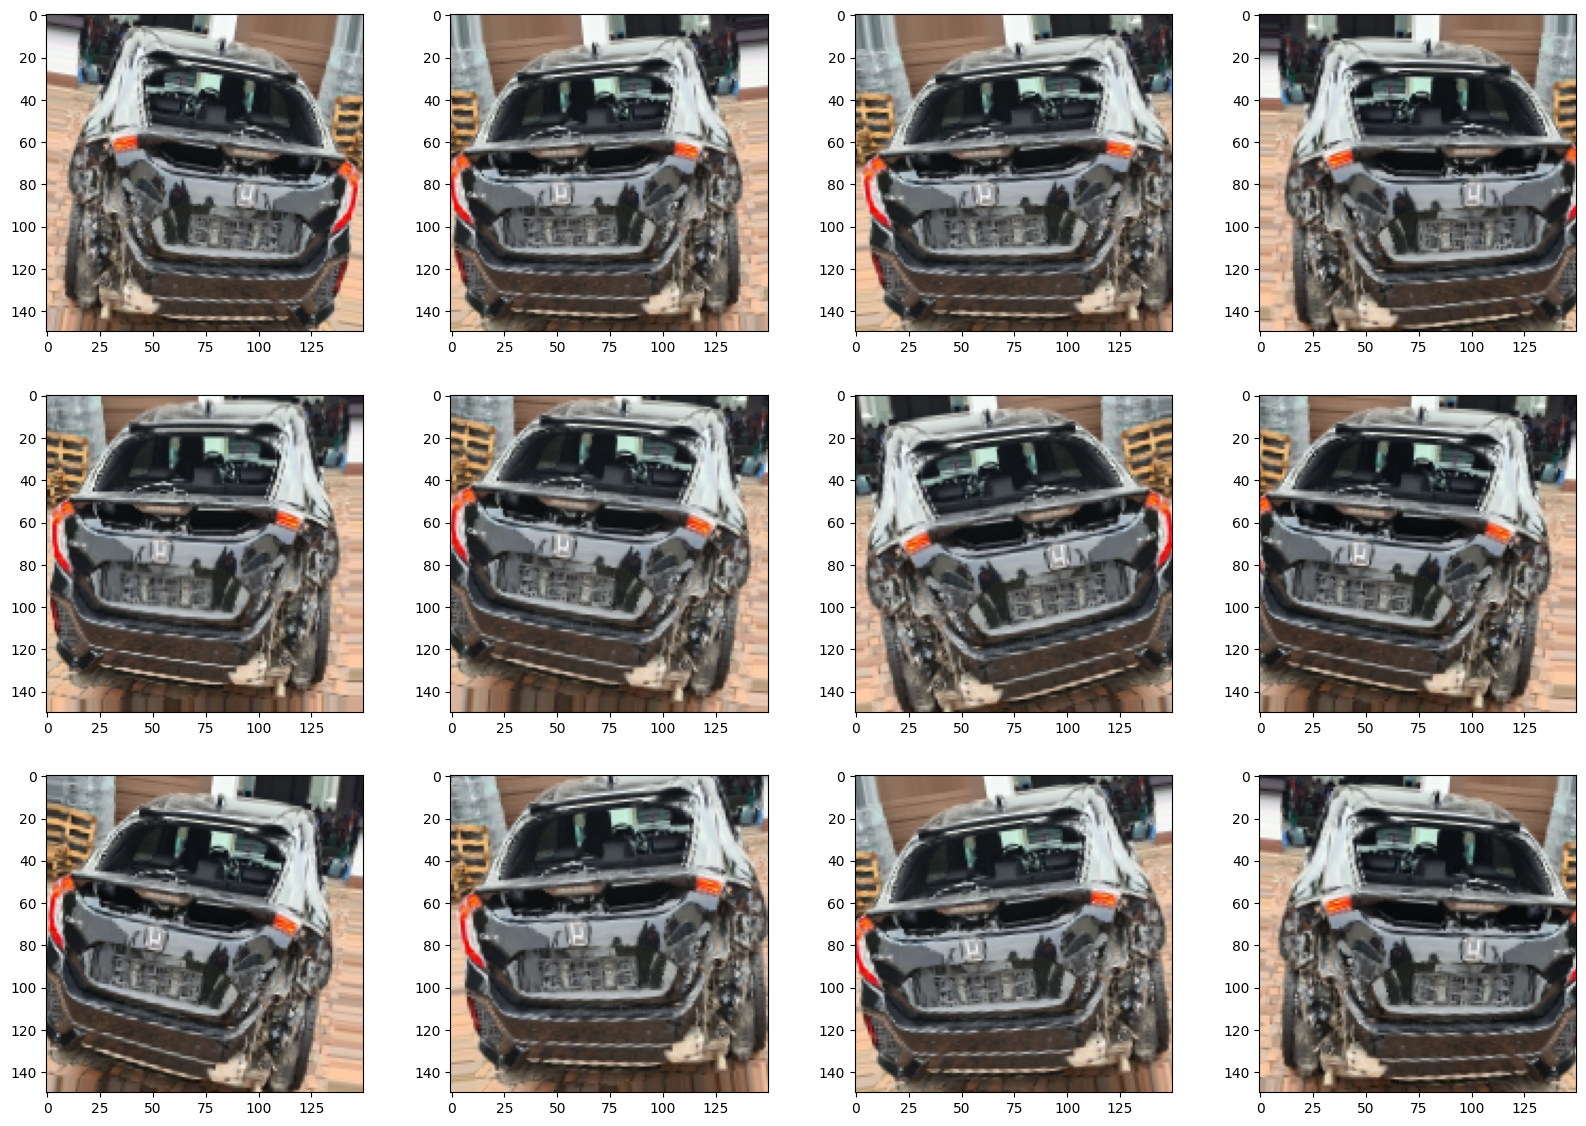

In [ ]:
#@title Wybierz index obrazka w celu jego eksploracji

index = 146 #@param {type:'slider', min:0, max:420}
display_augmented_images('splitted_images/train/damaged_cars', index)

### spr grayscale

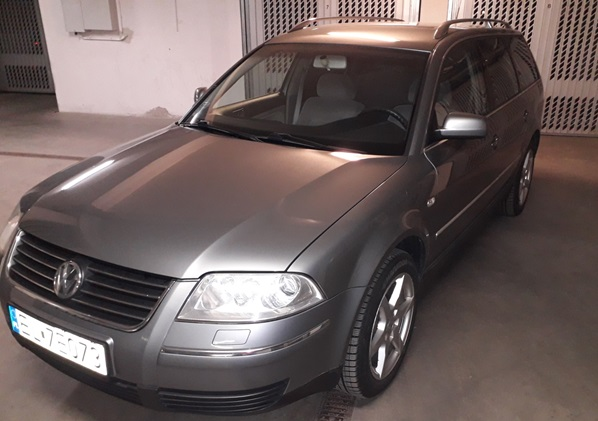

In [ ]:
test_img

In [ ]:
data = img_to_array(test_img)
data.shape

(421, 598, 3)

In [ ]:
samples = np.expand_dims(data, 0)
samples

array([[[[ 28.,  25.,  18.],
         [ 43.,  40.,  33.],
         [ 39.,  36.,  31.],
         ...,
         [ 35.,  17.,   5.],
         [ 89.,  70.,  63.],
         [138., 119., 112.]],

        [[ 32.,  29.,  22.],
         [ 45.,  42.,  35.],
         [ 42.,  39.,  34.],
         ...,
         [100.,  82.,  72.],
         [100.,  81.,  74.],
         [ 98.,  79.,  73.]],

        [[ 35.,  30.,  26.],
         [ 44.,  39.,  35.],
         [ 51.,  46.,  42.],
         ...,
         [100.,  81.,  75.],
         [ 43.,  24.,  20.],
         [ 94.,  75.,  71.]],

        ...,

        [[136., 118., 106.],
         [136., 118., 106.],
         [134., 116., 104.],
         ...,
         [115.,  97.,  85.],
         [114.,  96.,  84.],
         [113.,  95.,  83.]],

        [[134., 116., 104.],
         [134., 116., 104.],
         [134., 116., 104.],
         ...,
         [113.,  95.,  83.],
         [111.,  93.,  81.],
         [110.,  92.,  80.]],

        [[132., 114., 102.],
       

In [ ]:
# dodany jeden wymiar na początku
samples.shape

# tensor zdjęć;
# pierwsza wartość - ilość próbek zdjęć w danych
# kolejne - atrybuty naszego zdjęcia

(1, 421, 598, 3)

(421, 598, 3)
(421, 598, 3)
(421, 598, 3)
(421, 598, 3)
(421, 598, 3)
(421, 598, 3)
(421, 598, 3)
(421, 598, 3)
(421, 598, 3)


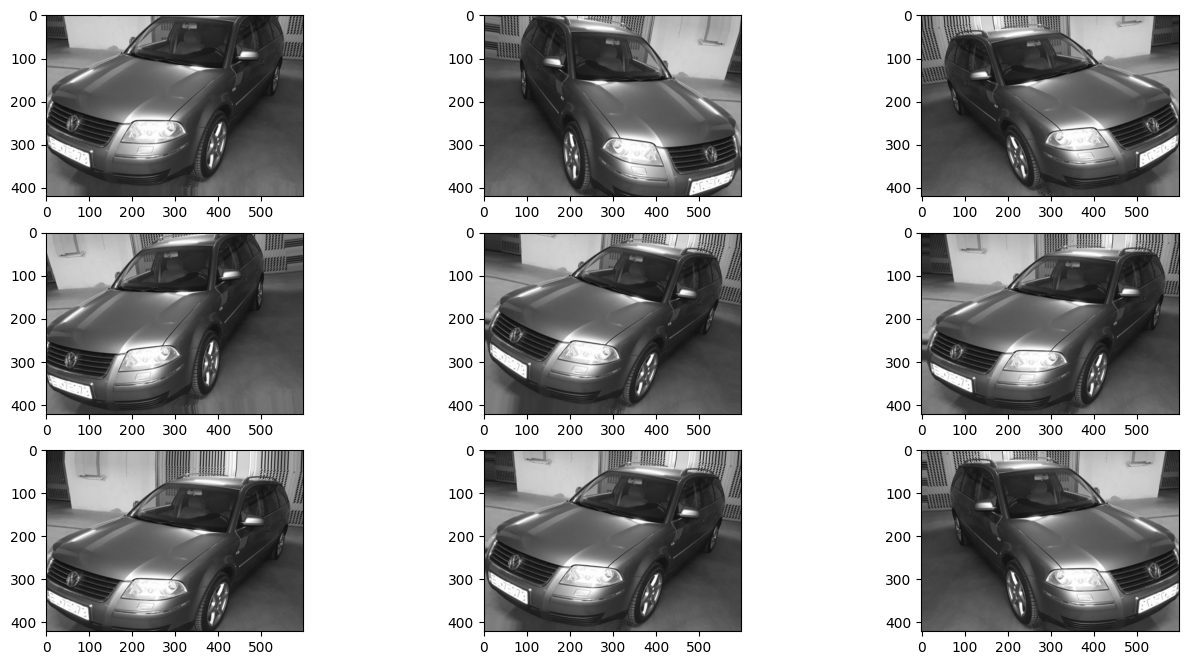

In [ ]:
# datagen = ImageDataGenerator() # instancja klasy
#                                # podczas trenowania modelu generuje dane w locie (nie są zapisywane na dysku) **



# train_datagen
datagen = ImageDataGenerator(

    preprocessing_function=image_to_grayscale,

    rotation_range=10,
#    rescale=1. / 255.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
    )


# generator do generowania danych w locie **
iterator = datagen.flow(samples, batch_size=1) # batch_size=1 -> rozmiar wsadu

plt.figure(figsize=(16, 8))
for i in range(9):
    plt.subplot(330 + i + 1)
    batch = iterator.next()
    img = batch[0].astype('uint8')
    plt.imshow(img)
    print(img.shape)
plt.show()
# tu generowane jest to samo zdjęcie (bo domyślne parametry przy tworzeniu instancji)

## Model

In [ ]:
INPUT_SHAPE

(224, 224, 3)

In [ ]:
# Przemka
MODEL_NAME = 'p_gray__'
model = Sequential([
    Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# podsumowanie modelu
model.summary()

In [ ]:
 MODEL_NAME = 'ag_10'

 model = Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), input_shape=INPUT_SHAPE, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),
        Flatten(),
        Dense(units=512, activation='relu'), # warstwa gęstopołączona
        #Dropout(0.5),
        Dense(units=1, activation='sigmoid')
        ])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 70, 70, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 35, 35, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 128)       7

In [ ]:
"""Conv2D(filters=64, kernel_size=(3, 3), input_shape=INPUT_SHAPE, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        ..."""
# parametry w warstwie I: (wymiary filtra * głębia koloru + 1) * ilość filtrów  -> (3*3 * 3 + 1) * 64 = 1792
# parametry w warstwie I: (wymiary filtra * poprzednia_ilość_filtrów + 1) * aktualna_ilość_filtrów -> (3*3 * 64 + 1) * 64 = 36928

In [ ]:
# kompilacja modelu
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    #optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Trening

In [ ]:
EPOCHS

50

In [ ]:
dt = datetime.now(pytz.timezone('Europe/Warsaw')).strftime('%d_%m_%Y_%H_%M') # aktualna data i czas (znacznik czasu)

filepath = os.path.join('output', 'model_' + f'{MODEL_NAME}_'+ dt + '.hdf5')  # nazwa pliku do zapisu **
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)  # zapis **
# ścieżka; metryka do minitorowania;  save_best_only=True -> najlepsze wagi

early_stopping = EarlyStopping(monitor='val_loss', patience=5)




print('[INFO] Trenowanie modelu...')
# history = model.fit_generator(
#     generator=train_generator,
#     steps_per_epoch=train_generator.samples // BATCH_SIZE,
#     validation_data=valid_generator,
#     validation_steps=valid_generator.samples // BATCH_SIZE,
#     epochs=EPOCHS, # EPOCHS
#     class_weight=class_weight,
#     verbose=2,
#     callbacks=[checkpoint, early_stopping]  # do zapisania najlepszego modelu
# )

# callbacks używamy np.:
# gdy nie jesteśmy w stanie określić ile epok potrzebujemy -> ustawiamy wywołania zwrotne, które w zależności np. od obserwowanej metryki i jej poprawy (lub nie) zatrzymuje trenowanie modelu
# możemy zapisywać każde wagi po każdej epoce
# możemy zapisywać tylko te wagi, które ulegają poprawie



# fit

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS, # EPOCHS
    class_weight=class_weight,
    verbose=2,
    callbacks=[checkpoint, early_stopping]  # do zapisania najlepszego modelu
)

[INFO] Trenowanie modelu...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



43/43 - 184s - loss: 1.0429 - accuracy: 0.5623 - val_loss: 0.6933 - val_accuracy: 0.2734 - 184s/epoch - 4s/step
Epoch 2/50
43/43 - 179s - loss: 1.0134 - accuracy: 0.2709 - val_loss: 0.6931 - val_accuracy: 0.5391 - 179s/epoch - 4s/step
Epoch 3/50
43/43 - 170s - loss: 1.0143 - accuracy: 0.7189 - val_loss: 0.6926 - val_accuracy: 0.7240 - 170s/epoch - 4s/step
Epoch 4/50
43/43 - 178s - loss: 1.0108 - accuracy: 0.2928 - val_loss: 0.6938 - val_accuracy: 0.2917 - 178s/epoch - 4s/step
Epoch 5/50
43/43 - 170s - loss: 1.0121 - accuracy: 0.5798 - val_loss: 0.6930 - val_accuracy: 0.7266 - 170s/epoch - 4s/step
Epoch 6/50
43/43 - 171s - loss: 1.0133 - accuracy: 0.3088 - val_loss: 0.6941 - val_accuracy: 0.2734 - 171s/epoch - 4s/step
Epoch 7/50
43/43 - 178s - loss: 1.0127 - accuracy: 0.5945 - val_loss: 0.6947 - val_accuracy: 0.4193 - 178s/epoch - 4s/step
Epoch 8/50
43/43 - 169s - loss: 1.0180 - accuracy: 0.5827 - val_loss: 0.6893 - val_accuracy: 0.4870 - 169s/epoch - 4s/step
Epoch 9/50
43/43 - 168s - l

## Eksport wyników trenowania i etykiet do plików

In [ ]:
# eksport wyników do plików (musimy utworzyć katalog 'output'; tu znajdą się wszystkie pliki 'wyprodukowane' w trakcie trenowania)
print('[INFO] Eksport wykresu do pliku html...')
filename = os.path.join('output', 'report_' f'{MODEL_NAME}_'+ dt + '.html')
plot_hist(history, filename=filename, show_plot=True)

[INFO] Eksport wykresu do pliku html...


In [ ]:
# info o mapowaniu klas
print('[INFO] Eksport etykiet do pliku...')
with open(r'output/labels.pickle', 'wb') as file:
    file.write(pickle.dumps(train_generator.class_indices))

[INFO] Eksport etykiet do pliku...


In [ ]:
# ag_10
# eksport wyników do plików (musimy utworzyć katalog 'output'; tu znajdą się wszystkie pliki 'wyprodukowane' w trakcie trenowania)
print('[INFO] Eksport wykresu do pliku html...')
filename = os.path.join('output', 'report_' f'{MODEL_NAME}_'+ dt + '.html')
plot_hist(history, filename=filename, show_plot=True)

[INFO] Eksport wykresu do pliku html...


## Sprawdzenie modelu na zbiorze testowym

In [ ]:
# p_gray__
check_model(model, TEST_DIR, INPUT_SHAPE)

Found 206 images belonging to 2 classes.
206/206 [==============================] - 3s 13ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[ 45  15]
 [ 38 108]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.54      0.75      0.63        60
     ok_cars       0.88      0.74      0.80       146

    accuracy                           0.74       206
   macro avg       0.71      0.74      0.72       206
weighted avg       0.78      0.74      0.75       206


[INFO] Dokładność modelu: 74.27%

[INFO] Błędnie sklasyfikowano: 53

[INFO] Nazwy plików:
damaged_cars/0077.jpg    0.931102
damaged_cars/0081.jpg    0.649437
damaged_cars/0102.jpg    0.549949
damaged_cars/0140.jpg    0.938551
damaged_cars/0181.jpg    0.986739
damaged_cars/0192.jpg    0.942909
damaged_cars/0196.jpg    0.841332
damaged_cars/0286.jpg    0.745103
damaged_cars/0298.jpg    0.525116
damaged_cars/0425.jpg    0.985743
damaged_cars/0487.jpg 

In [ ]:
# ag_10
check_model(model, TEST_DIR, INPUT_SHAPE)

Found 201 images belonging to 2 classes.
201/201 [==============================] - 8s 41ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[39 16]
 [87 59]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.31      0.71      0.43        55
     ok_cars       0.79      0.40      0.53       146

    accuracy                           0.49       201
   macro avg       0.55      0.56      0.48       201
weighted avg       0.66      0.49      0.51       201


[INFO] Dokładność modelu: 48.76%

[INFO] Błędnie sklasyfikowano: 103

[INFO] Nazwy plików:
damaged_cars/0007.jpg    0.501411
damaged_cars/0013.jpg    0.528863
damaged_cars/0027.jpg    0.501965
damaged_cars/0030.jpg    0.555022
damaged_cars/0071.jpg    0.554875
                           ...   
ok_cars/1393.jpg         0.449962
ok_cars/1398.jpg         0.434773
ok_cars/1424.jpg         0.419843
ok_cars/1425.jpg         0.418410
ok_cars/1459.jpg         

### sprawdzenie modelu na pojedynczym zdjęciu

1/1 [==============================] - 0s 105ms/step
y_pred: 0.49614351987838745
damaged_cars


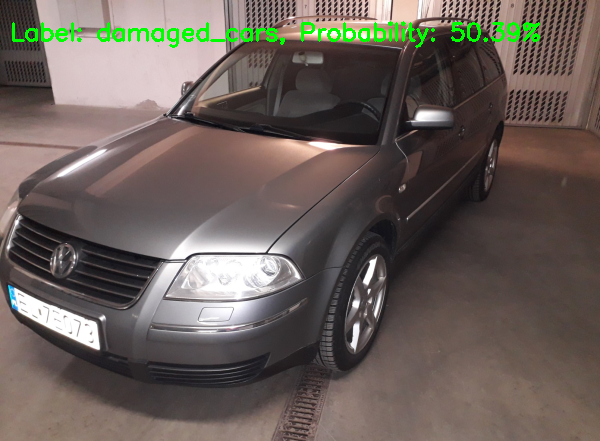

In [ ]:
predict_class('/content/pasek.jpg', model, INPUT_SHAPE, '/content/output/labels.pickle')

1/1 [==============================] - 0s 111ms/step
y_pred: 0.17306311428546906
damaged_cars


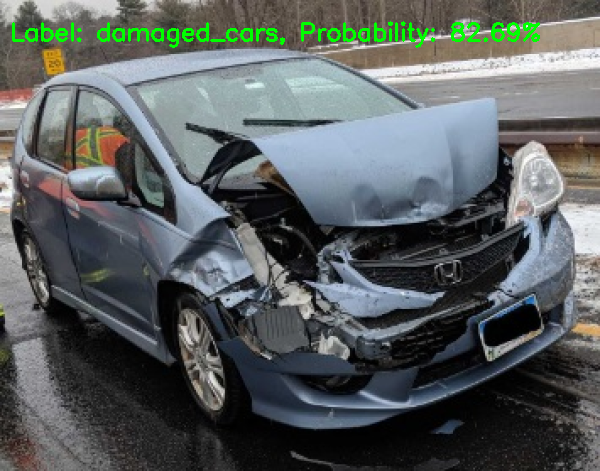

In [ ]:
predict_class('/content/d1.jpg', model, INPUT_SHAPE, '/content/output/labels.pickle')

# Transfer Learning

## Transfer Learning I (VGG16)

In [ ]:
# z pliku '01_convnet.ipynb'
# https://towardsdatascience.com/transfer-learning-in-speech-emotion-recognition-d55b6616ba83

from keras.applications import VGG16

vgg_model = VGG16(weights='imagenet',  # wagi przetrenowana na zbiorze imagenet
                 include_top=False,    # czy dołączyć górną cześć sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                 input_shape=INPUT_SHAPE) # (150, 150, 3)

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(1024, activation='relu')(x) #
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
transfer_model.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
class_weight

{0: 2.7, 1: 1.0}

In [ ]:
MODEL_NAME = 'transfer_'

dt = datetime.now(pytz.timezone('Europe/Warsaw')).strftime('%d_%m_%Y_%H_%M') # aktualna data i czas (znacznik czasu)

filepath = os.path.join('output', 'model_' + f'{MODEL_NAME}_'+ dt + '.hdf5')  # nazwa pliku do zapisu **
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)  # zapis **
# ścieżka; metryka do minitorowania;  save_best_only=True -> najlepsze wagi

early_stopping = EarlyStopping(monitor='val_loss', patience=7)


history = transfer_model.fit_generator(train_generator,
                                       validation_data=valid_generator,
                                       epochs=50,
                                       verbose=2,
                                       class_weight=class_weight,
                                       callbacks=[checkpoint, early_stopping])

<ipython-input-53-944720270768>:12: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
44/44 - 760s - loss: 1.7382 - accuracy: 0.5936 - val_loss: 0.4082 - val_accuracy: 0.8155 - 760s/epoch - 17s/step
Epoch 2/50
44/44 - 702s - loss: 0.7228 - accuracy: 0.7580 - val_loss: 0.3742 - val_accuracy: 0.8279 - 702s/epoch - 16s/step
Epoch 3/50
44/44 - 706s - loss: 0.5546 - accuracy: 0.8335 - val_loss: 0.2871 - val_accuracy: 0.8978 - 706s/epoch - 16s/step
Epoch 4/50
44/44 - 696s - loss: 0.4602 - accuracy: 0.8633 - val_loss: 0.2976 - val_accuracy: 0.8653 - 696s/epoch - 16s/step
Epoch 5/50
44/44 - 697s - loss: 0.4497 - accuracy: 0.8676 - val_loss: 0.2157 - val_accuracy: 0.9052 - 697s/epoch - 16s/step
Epoch 6/50
44/44 - 751s - loss: 0.3639 - accuracy: 0.9004 - val_loss: 0.2099 - val_accuracy: 0.8928 - 751s/epoch - 17s/step
Epoch 7/50
44/44 - 747s - loss: 0.2571 - accuracy: 0.9295 - val_loss: 0.2182 - val_accuracy: 0.8978 - 747s/epoch - 17s/step
Epoch 8/50
44/44 - 695s - loss: 0.2410 - accuracy: 0.9388 - val_loss: 0.3192 - val_accuracy: 0.8753 - 695s/epoch - 16s/step
Epoch 9/

## Sprawdzenie modelu na zbiorze testowym

In [ ]:
check_model(transfer_model, TEST_DIR, INPUT_SHAPE)

Found 201 images belonging to 2 classes.
201/201 [==============================] - 55s 274ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[ 35  20]
 [  6 140]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.85      0.64      0.73        55
     ok_cars       0.88      0.96      0.92       146

    accuracy                           0.87       201
   macro avg       0.86      0.80      0.82       201
weighted avg       0.87      0.87      0.86       201


[INFO] Dokładność modelu: 87.06%

[INFO] Błędnie sklasyfikowano: 26

[INFO] Nazwy plików:
damaged_cars/0030.jpg    0.890873
damaged_cars/0071.jpg    0.999691
damaged_cars/0109.jpg    0.935196
damaged_cars/0138.jpg    0.995107
damaged_cars/0163.jpg    0.960428
damaged_cars/0164.jpg    0.890313
damaged_cars/0183.jpg    0.703020
damaged_cars/0194.jpg    0.996370
damaged_cars/0208.jpg    0.815264
damaged_cars/0210.jpg    0.998700
damaged_cars/0219.jp

## Wczytanie wytrenowanego modelu z dysku

In [ ]:
# Wczytanie modelu "model_transfer_1_31_12_2023_07_59.hdf5"

# from tensorflow.keras.models import load_model

loaded_t1_model = load_model('output/model_transfer_1_31_12_2023_07_59.hdf5')
loaded_t1_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Sprawdzenie wczytanego modelu na zbiorze testowym

In [ ]:
check_model(loaded_t1_model, TEST_DIR, INPUT_SHAPE)

Found 201 images belonging to 2 classes.
201/201 [==============================] - 66s 327ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[ 51   4]
 [  5 141]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.91      0.93      0.92        55
     ok_cars       0.97      0.97      0.97       146

    accuracy                           0.96       201
   macro avg       0.94      0.95      0.94       201
weighted avg       0.96      0.96      0.96       201


[INFO] Dokładność modelu: 95.52%

[INFO] Błędnie sklasyfikowano: 9

[INFO] Nazwy plików:
damaged_cars/0048.jpg    0.564873
damaged_cars/0299.jpg    0.648914
damaged_cars/0429.jpg    0.925322
damaged_cars/0504.jpg    0.501962
ok_cars/0008.jpg         0.086972
ok_cars/0806.jpg         0.062872
ok_cars/0902.jpg         0.378176
ok_cars/1333.jpg         0.397445
ok_cars/1432.jpg         0.353362
Name: y_prob, dtype: float32


### Sprawdzenie wczytanego modelu na nowym zbiorze testowym (pobrane 19.01.2024)

In [ ]:
!unzip '/content/test_images_19_01_2024.zip'

In [ ]:
new_test_dir = 'test_images_19_01_2024'

In [ ]:
check_model(loaded_t1_model, new_test_dir, INPUT_SHAPE)

Found 60 images belonging to 2 classes.
60/60 [==============================] - 17s 281ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[33  7]
 [ 4 16]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.89      0.82      0.86        40
     ok_cars       0.70      0.80      0.74        20

    accuracy                           0.82        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.83      0.82      0.82        60


[INFO] Dokładność modelu: 81.67%

[INFO] Błędnie sklasyfikowano: 11

[INFO] Nazwy plików:
damaged_cars/01.jpg    0.910149
damaged_cars/02.jpg    0.601645
damaged_cars/03.jpg    0.782657
damaged_cars/08.jpg    0.527358
damaged_cars/14.jpg    0.712358
damaged_cars/18.jpg    0.678783
damaged_cars/35.jpg    0.909179
ok_cars/108.jpg        0.274462
ok_cars/110.jpg        0.278929
ok_cars/115.jpg        0.334716
ok_cars/118.jpg        0.250804
Name: y_prob, d

### sprawdzenie modelu na pojedynczym zdjęciu

1/1 [==============================] - 1s 664ms/step
y_pred: 0.6748729944229126
ok_cars


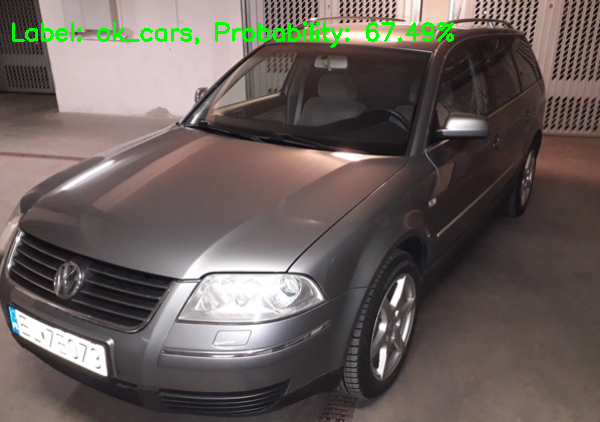

In [ ]:
predict_class('/content/pasek.jpg', loaded_t1_model, INPUT_SHAPE, '/content/output/labels.pickle')

1/1 [==============================] - 0s 250ms/step
y_pred: 0.012265168130397797
damaged_cars


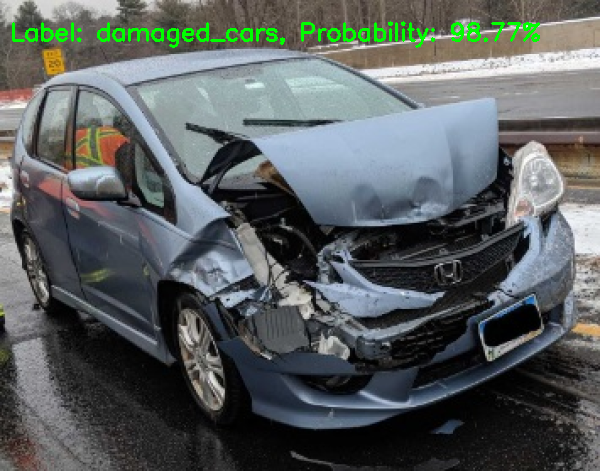

In [ ]:
predict_class('/content/d1.jpg', loaded_t1_model, INPUT_SHAPE, '/content/output/labels.pickle')

## Transfer Learning Iv2 (VGG16)

In [ ]:
# z pliku '01_convnet.ipynb'
# https://towardsdatascience.com/transfer-learning-in-speech-emotion-recognition-d55b6616ba83

from keras.applications import VGG16

vgg_model = VGG16(weights='imagenet',  # wagi przetrenowana na zbiorze imagenet
                 include_top=False,    # czy dołączyć górną cześć sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                 input_shape=INPUT_SHAPE) # (150, 150, 3)

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
#x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
extended_vgg16_model = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
extended_vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Total params: 41062209 (156.64 MB)
# Trainable params: 41062209 (156.64 MB)
# Non-trainable params: 0 (0.00 Byte)

In [ ]:
extended_vgg16_model.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
class_weight

{0: 2.7, 1: 1.0}

In [ ]:
MODEL_NAME = 'transfer_3__'

dt = datetime.now(pytz.timezone('Europe/Warsaw')).strftime('%d_%m_%Y_%H_%M') # aktualna data i czas (znacznik czasu)

filepath = os.path.join('output', 'model_' + f'{MODEL_NAME}_'+ dt + '.hdf5')  # nazwa pliku do zapisu **
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)  # zapis **
# ścieżka; metryka do minitorowania;  save_best_only=True -> najlepsze wagi

early_stopping = EarlyStopping(monitor='val_loss', patience=6)


# history = extended_vgg16_model.fit_generator(train_generator,
#                                        validation_data=valid_generator,
#                                        epochs=45,
#                                        verbose=2,
#                                        class_weight=class_weight,
#                                        callbacks=[checkpoint, early_stopping])


# fit

history = extended_vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
    # Całkowita liczba kroków (partii próbek) przed uznaniem zakończenia jednej epoki i rozpoczęciem następnej.

    # When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.
    # Podczas uczenia z tensorami wejściowymi, takimi jak tensory danych TensorFlow, domyślna wartość Brak jest równa liczbie próbek w zestawie danych podzielonej przez rozmiar partii lub 1, jeśli nie można tego określić.

    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS, # EPOCHS
    class_weight=class_weight,
    verbose=2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
43/43 - 3034s - loss: 1.9819 - accuracy: 0.4996 - val_loss: 0.6579 - val_accuracy: 0.7318 - 3034s/epoch - 71s/step
Epoch 2/50


KeyboardInterrupt: 

## Transfer Learning II (VGG16 + dostrajanie)

### Dostrajanie v1

('odmrożenie' kilku górnych warstw zamrożonej bazy modelu. Dostroimy trzy ostatnie warstwy konwolucyjne (`block5_conv1, block5_conv2, block5_conv3`))

In [ ]:
INPUT_SHAPE

(150, 150, 3)

In [ ]:
# z pliku '01_convnet.ipynb'
# https://towardsdatascience.com/transfer-learning-in-speech-emotion-recognition-d55b6616ba83

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',  # wagi przetrenowana na zbiorze imagenet
                 include_top=False,    # czy dołączyć górną cześć sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                 input_shape=INPUT_SHAPE) # (150, 150, 3)

conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# ilość parametrów w 1-ej warstwie (wymiary filtra * głębia koloru + 1) * ilość filtrów
# ilość parametrów w kolejnej warstwie (wymiary filtra * ilość filtrów w poprzedniej warstwie + 1) * aktualna ilość filtrów

# warstwa 1 (2 licząc z inputem):    ([3 * 3] * 3 + 1) * 64 = 28 * 64 = 1792

# warstwa 2 (3):    ([3 * 3] * 64 + 1) * 64 = 36928

# warstwa 3:    ([3 * 3] * 64 + 1) * 128 = 73856

In [ ]:
28 * 64

1792

In [ ]:
(3 * 3 * 64 + 1) * 64

36928

In [ ]:
(3 * 3 * 64 + 1) * 128

73856

In [ ]:
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:12}, trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_1     , trainable: True
layer_name: block1_conv1, trainable: True
layer_name: block1_conv2, trainable: True
layer_name: block1_pool , trainable: True
layer_name: block2_conv1, trainable: True
layer_name: block2_conv2, trainable: True
layer_name: block2_pool , trainable: True
layer_name: block3_conv1, trainable: True
layer_name: block3_conv2, trainable: True
layer_name: block3_conv3, trainable: True
layer_name: block3_pool , trainable: True
layer_name: block4_conv1, trainable: True
layer_name: block4_conv2, trainable: True
layer_name: block4_conv3, trainable: True
layer_name: block4_pool , trainable: True
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [ ]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_1     , trainable: False
layer_name: block1_conv1, trainable: False
layer_name: block1_conv2, trainable: False
layer_name: block1_pool , trainable: False
layer_name: block2_conv1, trainable: False
layer_name: block2_conv2, trainable: False
layer_name: block2_pool , trainable: False
layer_name: block3_conv1, trainable: False
layer_name: block3_conv2, trainable: False
layer_name: block3_conv3, trainable: False
layer_name: block3_pool , trainable: False
layer_name: block4_conv1, trainable: False
layer_name: block4_conv2, trainable: False
layer_name: block4_conv3, trainable: False
layer_name: block4_pool , trainable: False
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [ ]:
conv_base.input

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
x = conv_base.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
transfer_model_2 = Model(inputs=conv_base.input, outputs=x)

In [ ]:
transfer_model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# 19041089

In [ ]:
# Total params: 27691841 (105.64 MB)
# Trainable params: 20056577 (76.51 MB)
# Non-trainable params: 7635264 (29.13 MB)

### Trenowanie modelu transfer_2

In [ ]:
transfer_model_2.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
class_weight

{0: 2.4, 1: 1.0}

In [ ]:
MODEL_NAME = 'transfer_v2_'

dt = datetime.now(pytz.timezone('Europe/Warsaw')).strftime('%d_%m_%Y_%H_%M') # aktualna data i czas (znacznik czasu)

filepath = os.path.join('output', 'model_' + f'{MODEL_NAME}_'+ dt + '.hdf5')  # nazwa pliku do zapisu **
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)  # zapis **
# ścieżka; metryka do minitorowania;  save_best_only=True -> najlepsze wagi

early_stopping = EarlyStopping(monitor='val_loss', patience=5)


history = transfer_model_2.fit_generator(train_generator,
                                       validation_data=valid_generator,
                                       epochs=50,
                                       verbose=2,
                                       class_weight=class_weight,
                                       callbacks=[checkpoint, early_stopping])

<ipython-input-40-616db09b1df2>:12: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



46/46 - 563s - loss: 1.1999 - accuracy: 0.5492 - val_loss: 0.6923 - val_accuracy: 0.7105 - 563s/epoch - 12s/step
Epoch 2/50
46/46 - 596s - loss: 0.9763 - accuracy: 0.3544 - val_loss: 0.6943 - val_accuracy: 0.2895 - 596s/epoch - 13s/step
Epoch 3/50
46/46 - 599s - loss: 0.9757 - accuracy: 0.5236 - val_loss: 0.6876 - val_accuracy: 0.7105 - 599s/epoch - 13s/step
Epoch 4/50
46/46 - 591s - loss: 0.9759 - accuracy: 0.7087 - val_loss: 0.6869 - val_accuracy: 0.7105 - 591s/epoch - 13s/step
Epoch 5/50
46/46 - 592s - loss: 0.9762 - accuracy: 0.7087 - val_loss: 0.6837 - val_accuracy: 0.7105 - 592s/epoch - 13s/step
Epoch 6/50
46/46 - 556s - loss: 0.9763 - accuracy: 0.7087 - val_loss: 0.6869 - val_accuracy: 0.7105 - 556s/epoch - 12s/step
Epoch 7/50
46/46 - 594s - loss: 0.9760 - accuracy: 0.7087 - val_loss: 0.6861 - val_accuracy: 0.7105 - 594s/epoch - 13s/step
Epoch 8/50
46/46 - 592s - loss: 0.9764 - accuracy: 0.7087 - val_loss: 0.6820 - val_accuracy: 0.7105 - 592s/epoch - 13s/step
Epoch 9/50
46/46 - 

### Wczytanie wytrenowanego modelu z dysku

In [ ]:
loaded_t_v2_model = load_model('output/model_transfer_v2__04_01_2024_22_55.hdf5')
loaded_t_v2_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Sprawdzenie wczytanego modelu na zbiorze testowym

In [ ]:
new_test_dir

'test_images_19_01_2024'

In [ ]:
check_model(loaded_t_v2_model, new_test_dir, INPUT_SHAPE)

Found 60 images belonging to 2 classes.
60/60 [==============================] - 16s 263ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[ 0 40]
 [ 0 20]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.00      0.00      0.00        40
     ok_cars       0.33      1.00      0.50        20

    accuracy                           0.33        60
   macro avg       0.17      0.50      0.25        60
weighted avg       0.11      0.33      0.17        60


[INFO] Dokładność modelu: 33.33%

[INFO] Błędnie sklasyfikowano: 40

[INFO] Nazwy plików:
damaged_cars/01.jpg    0.501007
damaged_cars/02.jpg    0.501007
damaged_cars/03.jpg    0.501007
damaged_cars/04.jpg    0.501007
damaged_cars/05.jpg    0.501007
damaged_cars/06.jpg    0.501007
damaged_cars/07.jpg    0.501007
damaged_cars/08.jpg    0.501007
damaged_cars/09.jpg    0.501007
damaged_cars/10.jpg    0.501007
damaged_cars/11.jpg    0.501007
damaged_cars/12

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Dostrajanie v2

In [ ]:
# z pliku '01_convnet.ipynb'
# https://towardsdatascience.com/transfer-learning-in-speech-emotion-recognition-d55b6616ba83

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',  # wagi przetrenowana na zbiorze imagenet
                 include_top=False,    # czy dołączyć górną cześć sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                 input_shape=INPUT_SHAPE) # (150, 150, 3)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:12}, trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_2     , trainable: True
layer_name: block1_conv1, trainable: True
layer_name: block1_conv2, trainable: True
layer_name: block1_pool , trainable: True
layer_name: block2_conv1, trainable: True
layer_name: block2_conv2, trainable: True
layer_name: block2_pool , trainable: True
layer_name: block3_conv1, trainable: True
layer_name: block3_conv2, trainable: True
layer_name: block3_conv3, trainable: True
layer_name: block3_pool , trainable: True
layer_name: block4_conv1, trainable: True
layer_name: block4_conv2, trainable: True
layer_name: block4_conv3, trainable: True
layer_name: block4_pool , trainable: True
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [ ]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_2     , trainable: False
layer_name: block1_conv1, trainable: False
layer_name: block1_conv2, trainable: False
layer_name: block1_pool , trainable: False
layer_name: block2_conv1, trainable: False
layer_name: block2_conv2, trainable: False
layer_name: block2_pool , trainable: False
layer_name: block3_conv1, trainable: False
layer_name: block3_conv2, trainable: False
layer_name: block3_conv3, trainable: False
layer_name: block3_pool , trainable: False
layer_name: block4_conv1, trainable: False
layer_name: block4_conv2, trainable: False
layer_name: block4_conv3, trainable: False
layer_name: block4_pool , trainable: False
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [ ]:
transfer_model_3 = Sequential() # instancja klasy
transfer_model_3.add(conv_base) # dodajemy (baze) model VGG16 (conv_base) do naszego modelu (jako pierwsza warstwa)
transfer_model_3.add(Flatten()) # wypłaszczy wejścia (z ostatniej warstwy conv_base; (None, 4, 4, 512))
transfer_model_3.add(Dense(units=256, activation='relu')) # warstwa gęstopołączona (256 neuronów ukrytych)
transfer_model_3.add(Dense(units=1, activation='sigmoid')) # 1 bo problem binarny; sigmoid - zwróci prawdopodobieństwo przynależności do poszczególnej klasy
transfer_model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 13502465 (51.51 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [ ]:
transfer_model_3.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
class_weight

{0: 2.4, 1: 1.0}

In [ ]:
MODEL_NAME = 'transfer_v3__'

dt = datetime.now(pytz.timezone('Europe/Warsaw')).strftime('%d_%m_%Y_%H_%M')

filepath = os.path.join('output', 'model_' + f'{MODEL_NAME}_'+ dt + '.hdf5')
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)


early_stopping = EarlyStopping(monitor='val_loss', patience=5)


history = transfer_model_3.fit_generator(train_generator,
                                       validation_data=valid_generator,
                                       epochs=50,
                                       verbose=2,
                                       class_weight=class_weight,
                                       callbacks=[checkpoint, early_stopping])

<ipython-input-34-5fca387a6109>:12: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



46/46 - 821s - loss: 1.1208 - accuracy: 0.5049 - val_loss: 0.6972 - val_accuracy: 0.2895 - 821s/epoch - 18s/step
Epoch 2/50
46/46 - 817s - loss: 1.0458 - accuracy: 0.3114 - val_loss: 0.6977 - val_accuracy: 0.2895 - 817s/epoch - 18s/step
Epoch 3/50
46/46 - 813s - loss: 0.9760 - accuracy: 0.2913 - val_loss: 0.6970 - val_accuracy: 0.2895 - 813s/epoch - 18s/step
Epoch 4/50
46/46 - 869s - loss: 0.9760 - accuracy: 0.2913 - val_loss: 0.6935 - val_accuracy: 0.2895 - 869s/epoch - 19s/step
Epoch 5/50
46/46 - 813s - loss: 0.9758 - accuracy: 0.3495 - val_loss: 0.6934 - val_accuracy: 0.2895 - 813s/epoch - 18s/step
Epoch 6/50
46/46 - 814s - loss: 0.9758 - accuracy: 0.2913 - val_loss: 0.6931 - val_accuracy: 0.7105 - 814s/epoch - 18s/step
Epoch 7/50
46/46 - 861s - loss: 0.9758 - accuracy: 0.6297 - val_loss: 0.6932 - val_accuracy: 0.2895 - 861s/epoch - 19s/step
Epoch 8/50
46/46 - 863s - loss: 0.9758 - accuracy: 0.7018 - val_loss: 0.6928 - val_accuracy: 0.7105 - 863s/epoch - 19s/step
Epoch 9/50
46/46 - 

## Transfer Learning III (ResNet-50)

In [ ]:
INPUT_SHAPE

(150, 150, 3)

In [ ]:
# https://datagen.tech/guides/computer-vision/resnet-50/



#from keras.applications import ResNet50

pretrained_model_for_demo = tf.keras.applications.ResNet50(include_top=False,
    input_shape=INPUT_SHAPE,
    pooling='avg',
    #classes=5,
    weights='imagenet')

for each_layer in pretrained_model_for_demo.layers:
        each_layer.trainable=False


pretrained_model_for_demo.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 186, 186, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 90, 90, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 90, 90, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
demo_resnet_model = Sequential()

demo_resnet_model.add(pretrained_model_for_demo)

In [ ]:
demo_resnet_model.add(Flatten())
demo_resnet_model.add(Dense(512, activation='relu'))
demo_resnet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
demo_resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
demo_resnet_model.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
class_weight

{0: 2.4, 1: 1.0}

In [ ]:
INPUT_SHAPE

(180, 180, 3)

In [ ]:
MODEL_NAME = 'ResNet50_v1__'

dt = datetime.now(pytz.timezone('Europe/Warsaw')).strftime('%d_%m_%Y_%H_%M')

filepath = os.path.join('output', 'model_' + f'{MODEL_NAME}_'+ dt + '.hdf5')
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)


history = demo_resnet_model.fit_generator(train_generator,
                                       validation_data=valid_generator,
                                       epochs=50,
                                       verbose=2,
                                       class_weight=class_weight,
                                       callbacks=[checkpoint, early_stopping])

<ipython-input-64-74a289b6fd55>:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



46/46 - 269s - loss: 1.2690 - accuracy: 0.5166 - val_loss: 1.1659 - val_accuracy: 0.2895 - 269s/epoch - 6s/step
Epoch 2/50
46/46 - 257s - loss: 1.0659 - accuracy: 0.5014 - val_loss: 1.2136 - val_accuracy: 0.2895 - 257s/epoch - 6s/step
Epoch 3/50
46/46 - 258s - loss: 1.0278 - accuracy: 0.5284 - val_loss: 0.9491 - val_accuracy: 0.2895 - 258s/epoch - 6s/step
Epoch 4/50
46/46 - 259s - loss: 1.0037 - accuracy: 0.5264 - val_loss: 0.6693 - val_accuracy: 0.5839 - 259s/epoch - 6s/step
Epoch 5/50
46/46 - 255s - loss: 0.9342 - accuracy: 0.6255 - val_loss: 0.7865 - val_accuracy: 0.3601 - 255s/epoch - 6s/step
Epoch 6/50
46/46 - 255s - loss: 0.9638 - accuracy: 0.5596 - val_loss: 0.7325 - val_accuracy: 0.4380 - 255s/epoch - 6s/step
Epoch 7/50
46/46 - 256s - loss: 0.9300 - accuracy: 0.6359 - val_loss: 0.7607 - val_accuracy: 0.4209 - 256s/epoch - 6s/step
Epoch 8/50
46/46 - 258s - loss: 0.9901 - accuracy: 0.5680 - val_loss: 0.7302 - val_accuracy: 0.4696 - 258s/epoch - 6s/step
Epoch 9/50
46/46 - 258s - l

### Eksport wyników trenowania i etykiet do plików

In [ ]:
# eksport wyników do plików (musimy utworzyć katalog 'output'; tu znajdą się wszystkie pliki 'wyprodukowane' w trakcie trenowania)
print('[INFO] Eksport wykresu do pliku html...')
filename = os.path.join('output', 'report_' f'{MODEL_NAME}_'+ dt + '.html')
plot_hist(history, filename=filename, show_plot=True)

[INFO] Eksport wykresu do pliku html...


In [ ]:
# info o mapowaniu klas
print('[INFO] Eksport etykiet do pliku...')
with open(r'output/labels.pickle', 'wb') as file:
    file.write(pickle.dumps(train_generator.class_indices))

[INFO] Eksport etykiet do pliku...


### Sprawdzenie wczytanego modelu na zbiorze testowym

In [ ]:
check_model(demo_resnet_model, TEST_DIR, INPUT_SHAPE)

Found 206 images belonging to 2 classes.
206/206 [==============================] - 22s 100ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[36 24]
 [50 96]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.42      0.60      0.49        60
     ok_cars       0.80      0.66      0.72       146

    accuracy                           0.64       206
   macro avg       0.61      0.63      0.61       206
weighted avg       0.69      0.64      0.66       206


[INFO] Dokładność modelu: 64.08%

[INFO] Błędnie sklasyfikowano: 74

[INFO] Nazwy plików:
damaged_cars/0054.jpg    0.534688
damaged_cars/0057.jpg    0.540184
damaged_cars/0058.jpg    0.544035
damaged_cars/0116.jpg    0.505365
damaged_cars/0119.jpg    0.632542
                           ...   
ok_cars/1416.jpg         0.232211
ok_cars/1426.jpg         0.342012
ok_cars/1435.jpg         0.410633
ok_cars/1441.jpg         0.237663
ok_cars/1452.jpg        

### sprawdzenie modelu na pojedynczym zdjęciu

1/1 [==============================] - 0s 184ms/step
y_pred: 0.4799533486366272
damaged_cars


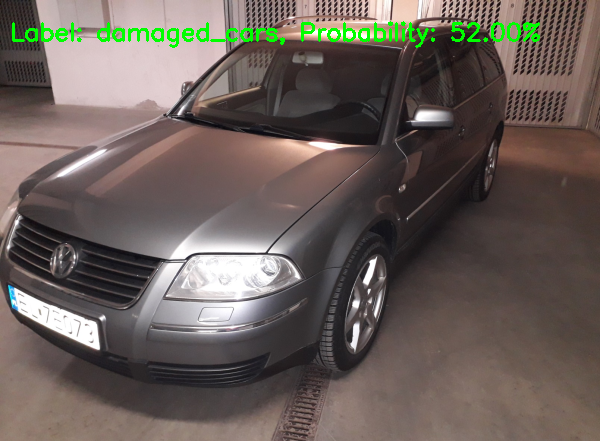

In [ ]:
predict_class('/content/pasek.jpg', demo_resnet_model, INPUT_SHAPE, '/content/output/labels.pickle')

1/1 [==============================] - 0s 169ms/step
y_pred: 0.30328911542892456
damaged_cars


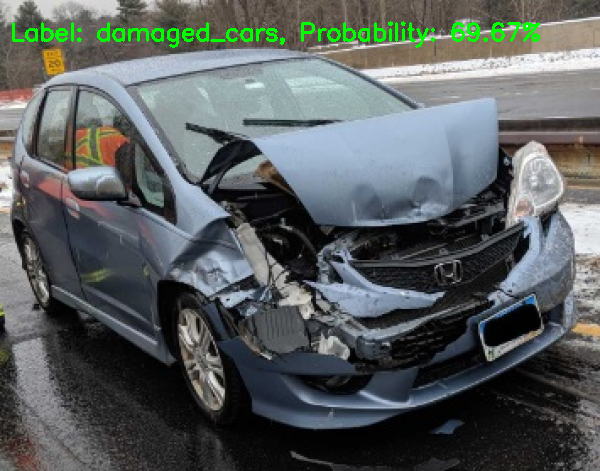

In [ ]:
predict_class('/content/d1.jpg', demo_resnet_model, INPUT_SHAPE, '/content/output/labels.pickle')

## Transfer Learning IV (EfficientNet B0)

In [ ]:
INPUT_SHAPE

(150, 150, 3)

In [ ]:
#tf.keras.applications.efficientnet.EfficientNetB0

from keras.applications.efficientnet import EfficientNetB0

efn_model = EfficientNetB0(weights='imagenet',
                 include_top=False,
                 input_shape=INPUT_SHAPE)

#efn_model.summary()

In [ ]:
for layer in efn_model.layers:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(efn_model.layers):
    print(i, layer.name, layer.trainable)

0 input_9 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [ ]:
x = efn_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(0.25)(x) # Dropout layer to reduce overfitting

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)


x = Dense(1, activation='sigmoid')(x)


efn_model = Model(inputs=efn_model.input, outputs=x)

In [ ]:
efn_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_10 (Rescaling)    (None, 150, 150, 3)          0         ['input_9[0][0]']             
                                                                                                  
 normalization_5 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_10[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_11 (Rescaling)    (None, 150, 150, 3)          0         ['normalization_5[0][0]'

In [ ]:
efn_model.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
class_weight

{0: 2.7, 1: 1.0}

In [ ]:
train_generator.samples

1405

In [ ]:
train_generator.samples // BATCH_SIZE

43

In [ ]:
MODEL_NAME = 'efn_B0__'

dt = datetime.now(pytz.timezone('Europe/Warsaw')).strftime('%d_%m_%Y_%H_%M')

filepath = os.path.join('output', 'model_' + f'{MODEL_NAME}_'+ dt + '.hdf5')

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)


# history = efn_model.fit_generator(train_generator,
#                                        validation_data=valid_generator,
#                                        epochs=30,
#                                        verbose=2,
#                                        class_weight=class_weight,
#                                        callbacks=[checkpoint, early_stopping])


# fit

history = efn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
    # Całkowita liczba kroków (partii próbek) przed uznaniem zakończenia jednej epoki i rozpoczęciem następnej.

    # When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.
    # Podczas uczenia z tensorami wejściowymi, takimi jak tensory danych TensorFlow, domyślna wartość Brak jest równa liczbie próbek w zestawie danych podzielonej przez rozmiar partii lub 1, jeśli nie można tego określić.

    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS, # EPOCHS
    class_weight=class_weight,
    verbose=2,
    callbacks=[checkpoint, early_stopping]
)

# https://www.tensorflow.org/api_docs/python/tf/keras/Model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



43/43 - 159s - loss: 1.2742 - accuracy: 0.5171 - val_loss: 14.3695 - val_accuracy: 0.7318 - 159s/epoch - 4s/step
Epoch 2/50
43/43 - 126s - loss: 1.1419 - accuracy: 0.4967 - val_loss: 1.0112 - val_accuracy: 0.7266 - 126s/epoch - 3s/step
Epoch 3/50
43/43 - 125s - loss: 1.0968 - accuracy: 0.4756 - val_loss: 7.1036 - val_accuracy: 0.2708 - 125s/epoch - 3s/step
Epoch 4/50
43/43 - 121s - loss: 1.0907 - accuracy: 0.5011 - val_loss: 0.9307 - val_accuracy: 0.2708 - 121s/epoch - 3s/step
Epoch 5/50
43/43 - 121s - loss: 1.1089 - accuracy: 0.4836 - val_loss: 0.5888 - val_accuracy: 0.7292 - 121s/epoch - 3s/step
Epoch 6/50
43/43 - 132s - loss: 1.0763 - accuracy: 0.4494 - val_loss: 0.7048 - val_accuracy: 0.2812 - 132s/epoch - 3s/step
Epoch 7/50
43/43 - 128s - loss: 1.0844 - accuracy: 0.5127 - val_loss: 0.6284 - val_accuracy: 0.7240 - 128s/epoch - 3s/step
Epoch 8/50
43/43 - 123s - loss: 1.1156 - accuracy: 0.5069 - val_loss: 0.6533 - val_accuracy: 0.7292 - 123s/epoch - 3s/step
Epoch 9/50
43/43 - 120s - 

In [ ]:
# https://keras.io/api/layers/normalization_layers/batch_normalization/
# https://keras.io/api/layers/regularizers/
# https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f

# Heatmap (do zrobienia!)

In [ ]:
loaded_t1_model = load_model('output/model_transfer_1_31_12_2023_07_59.hdf5')

OSError: ignored

In [ ]:
# https://medium.com/@feitgemel/advanced-computer-vision-tutorial-understanding-vgg16-with-gradcam-bebdbcb37820
# może ok?

In [ ]:
loaded_t1_model

In [ ]:
# pip install --upgrade tf-keras-vis tensorflow
# =============================================

from xml.etree.ElementInclude import include
import numpy as np
import cv2
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
loaded_t1_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# #load the Vgg16 model
# model = Model(weights='imagenet',include_top=True)
# print(model.summary())

# # 283	Persian cat
# # 150	sea lion

# # here is the link for imagenet classes : https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

# image_titles = ['Persian-cat','Sea-lion']

# # load the images

# img1=load_img("C:/GitHub/TensorFlowProjects/CNN-Visualization/Persian-cat.jpg", target_size=(224,224))
# img2=load_img("C:/GitHub/TensorFlowProjects/CNN-Visualization/Sea-lion.jpg", target_size=(224,224))


#img1 = load_img('/content/pasek.jpg')
img1 = cv2.imread('/content/pasek.jpg')
img1 = cv2.resize(img1, (150, 150))

img2 = cv2.imread('/content/0209.jpg')
img2 = cv2.resize(img2, (150, 150))

# ####
# image = cv2.imread(image_path)
# image = cv2.resize(image, (150, 150))
# image = image.astype('float') / 255.
# image = img_to_array(image)
# image = np.expand_dims(image, axis=0)
# ####

print(type(img1))

<class 'numpy.ndarray'>


In [ ]:
from google.colab.patches import cv2_imshow

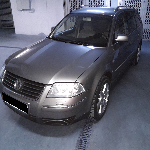

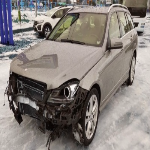

In [ ]:
# convert it to Numpy Array:
img1_array = cv2.cvtColor(np.array(img1),cv2.COLOR_RGB2BGR)
img2_array = cv2.cvtColor(np.array(img2),cv2.COLOR_RGB2BGR)
# img1_array = cv2.cvtColor(np.array(img1),cv2.COLOR_RGB2BGR)
# img2_array = cv2.cvtColor(np.array(img2),cv2.COLOR_RGB2BGR)

# Show the images

#cv2.imshow("Original car ", img1_array)
cv2_imshow(img1_array)
cv2_imshow(img2_array)
#cv2.imshow("Original - Sea-lion", img2_array)

In [ ]:
# prepare the data for the Vgg16 model
#images = np.asarray([np.array(img1), np.array(img2)])
images = np.asarray([np.array(img1)])
X = preprocess_input(images)

In [ ]:
# define the loss functions with a traget classes
def loss(output):
    #return(output[0][283], output[1][150])
    return(output[0][1], output[1][0])

In [ ]:
loaded_t1_model.layers

In [ ]:
loaded_t1_model.layers[-1].activation

<function keras.src.activations.sigmoid(x)>

In [ ]:
# define the model modifier - change the activation function
def model_modifier(mdl):
    mdl.layers[-1].activation = tf.keras.activations.linear # we change the activation function of last layer to linear

In [ ]:
pip install tf-keras-vis tensorflow

In [ ]:
# define the grand cam function
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

In [ ]:
# create an object

gradcam = Gradcam(loaded_t1_model,
                model_modifier=model_modifier,
                clone=False)

In [ ]:
loaded_t1_model.layers[-1].activation

<function keras.src.activations.linear(x)>

In [ ]:
cam = gradcam(loss, X , penultimate_layer=-1 )# the layer befor the softmax

InvalidArgumentError: ignored

In [ ]:
cam = gradcam(loss, X , penultimate_layer=-1 )# the layer befor the softmax

cam = normalize(cam)

# lets show the outcome :

# to extract the image from the model

heatmapImg1 = np.uint8(cm.jet(cam[0])[..., :3] * 255 )
# chnage the color map to jet
heatmapImg1 = cv2.applyColorMap(heatmapImg1 , cv2.COLORMAP_JET)

# lets add some alpha transparency
alpha = 0.5
overlay = heatmapImg1.copy() # copy the image
result1 = cv2.addWeighted(img1_array, alpha, heatmapImg1 , 1-alpha, 0)

scale_precent = 200
w = int(heatmapImg1.shape[1] * scale_precent / 100)
h = int(heatmapImg1.shape[0] * scale_precent / 100)
dim = (w,h)

result1 = cv2.resize(result1, dim , interpolation=cv2.INTER_AREA)
img1_array = cv2.resize(img1_array, dim , interpolation=cv2.INTER_AREA)

cv2.imshow("GradCam - Cat",result1 )
#cv2.imwrite("GradCam - Cat.jpg",result1 )
cv2.imshow("Original - Cat",img1_array )
cv2.waitKey(0)

# lets show the sea lion

heatmapImg2 = np.uint8(cm.jet(cam[1])[..., :3] * 255 )
heatmapImg2 = cv2.applyColorMap(heatmapImg2 , cv2.COLORMAP_JET)
overlay = heatmapImg2.copy() # copy the image
result2 = cv2.addWeighted(img2_array, alpha, heatmapImg2 , 1-alpha, 0)

w = int(heatmapImg2.shape[1] * scale_precent / 100)
h = int(heatmapImg2.shape[0] * scale_precent / 100)
dim = (w,h)

result2 = cv2.resize(result2, dim , interpolation=cv2.INTER_AREA)
img2_array = cv2.resize(img2_array, dim , interpolation=cv2.INTER_AREA)

cv2.imshow("GradCam - Sea lion",result2 )
cv2.imshow("Original - Sea lion",img2_array )
#cv2.imwrite("GradCam - Sea-lion.jpg",result2 )
cv2.waitKey(0)

InvalidArgumentError: ignored